In [1]:
%matplotlib inline
from new_methods.new_methods import My_NuScenes
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pythreejs as pjs
import pickle
import math as mt
from scipy.ndimage import zoom

nusc = My_NuScenes(version='v1.0-mini', dataroot='/data/datasets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.275 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [16]:
index = 83
nsweeps = 1

In [17]:
base_file_path = '/home/byounghun/workspace/CRN/occupancy'
file_n = 'occupancy_of_sample.npy'

occupancy = np.load(osp.join(base_file_path, file_n))
axes_limit = (occupancy.shape[3]-0.5, occupancy.shape[4]-0.5)
occupancy.shape

(6, 1, 1, 70, 44)

In [18]:
sample_record = nusc.get('sample', nusc.sample[index]['token'])
radar = ['RADAR_FRONT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 'RADAR_BACK_LEFT', 'RADAR_BACK_RIGHT']
camera = ['CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_FRONT_LEFT']
pointsensor_channel = radar
camera_channel = camera

pointsensor_token = [sample_record['data'][pointsensor_channel[i]] for i in range(len(pointsensor_channel))]
camera_token = [sample_record['data'][camera_channel[i]] for i in range(len(camera_channel))]

pointsensor_channel_L = ['LIDAR_TOP']
pointsensor_token_L = [sample_record['data'][pointsensor_channel_L[i]] for i in range(len(pointsensor_channel_L))]

points_result_L, depth_result_L, _ = nusc.map_multiview_pointcloud_to_image(pointsensor_token_L,
                                                                               pointsensor_channel_L,
                                                                               camera_token,
                                                camera_channel=camera_channel,
                                                nsweeps=nsweeps,
                                                render_intensity=False,
                                                show_lidarseg=False,
                                                filter_lidarseg_labels=None,
                                                lidarseg_preds_bin_path=None,
                                                show_panoptic=False)
points_result_R, depth_result_R, im_result = nusc.map_multiview_pointcloud_to_image(pointsensor_token,
                                                                               pointsensor_channel,
                                                                               camera_token,
                                                camera_channel=camera_channel,
                                                nsweeps=nsweeps,
                                                render_intensity=False,
                                                show_lidarseg=False,
                                                filter_lidarseg_labels=None,
                                                lidarseg_preds_bin_path=None,
                                                show_panoptic=False)

for key in camera:
    points_result_R[key][0] = points_result_R[key][0]*44/1600
    points_result_L[key][0] = points_result_L[key][0]*44/1600
    points_result_R[key][2] = depth_result_R[key]
    points_result_L[key][2] = depth_result_L[key]
    points_result_R[key] = np.delete(points_result_R[key], 1 , axis = 0)
    points_result_L[key] = np.delete(points_result_L[key], 1 , axis = 0)

points_result_origin, depth_result_origin, _ = nusc.map_multiview_pointcloud_to_image(pointsensor_token,
                                                                               pointsensor_channel,
                                                                               camera_token,
                                                camera_channel=camera_channel,
                                                nsweeps=nsweeps,
                                                render_intensity=False,
                                                show_lidarseg=False,
                                                filter_lidarseg_labels=None,
                                                lidarseg_preds_bin_path=None,
                                                show_panoptic=False)

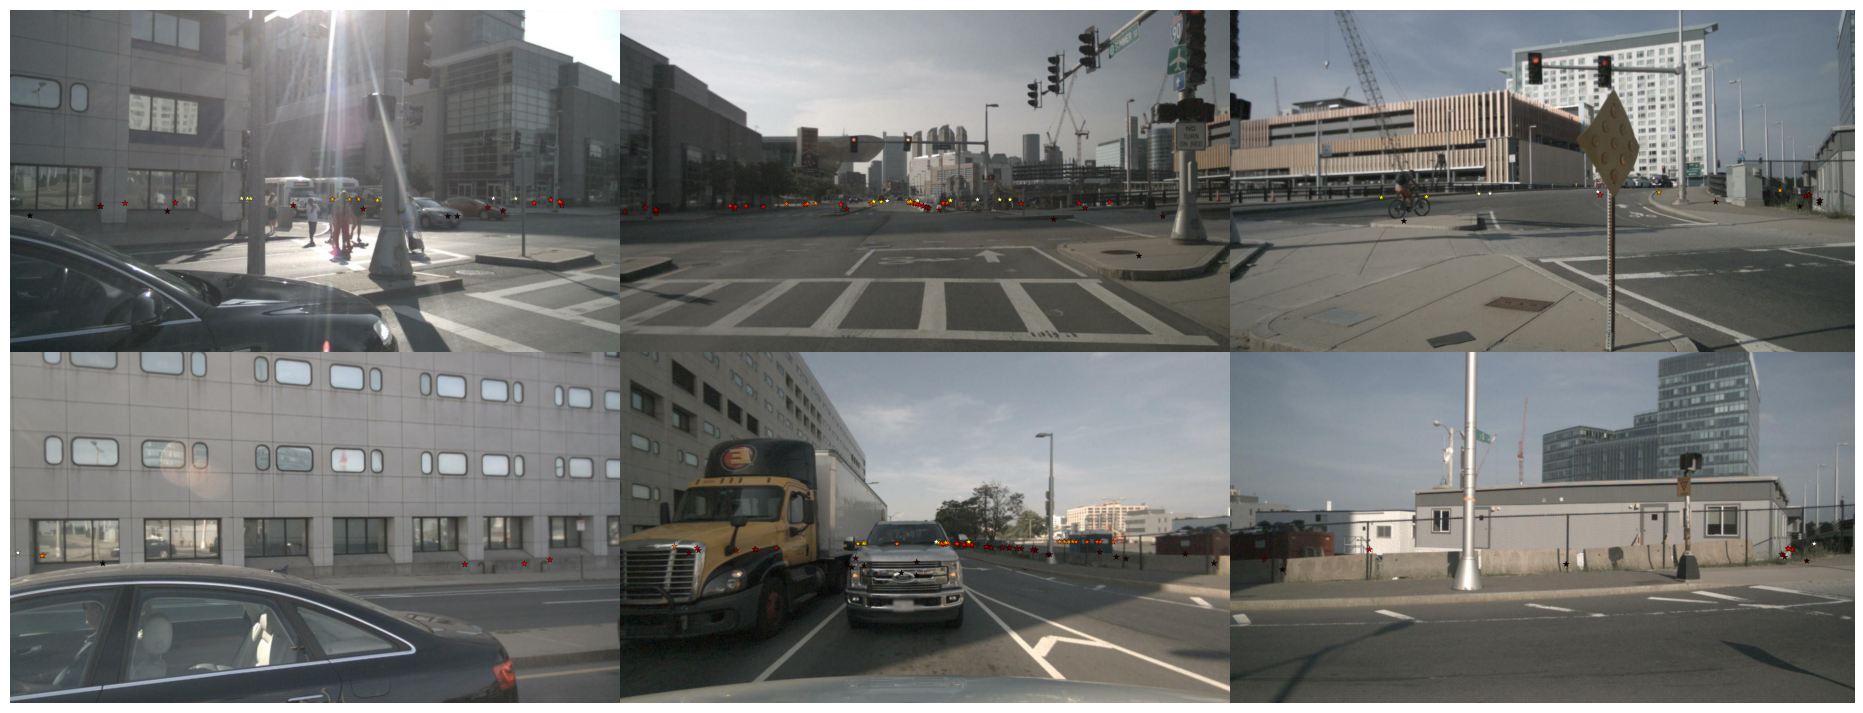

In [19]:
nusc.render_pointcloud_in_scene(nusc.sample[index]['token'], nsweeps = nsweeps, dot_size = 20, show_both_modality=False, verbose=True, out_path = '/home/byounghun/workspace/CRN/radar_sample_'+str(index)+'.png')

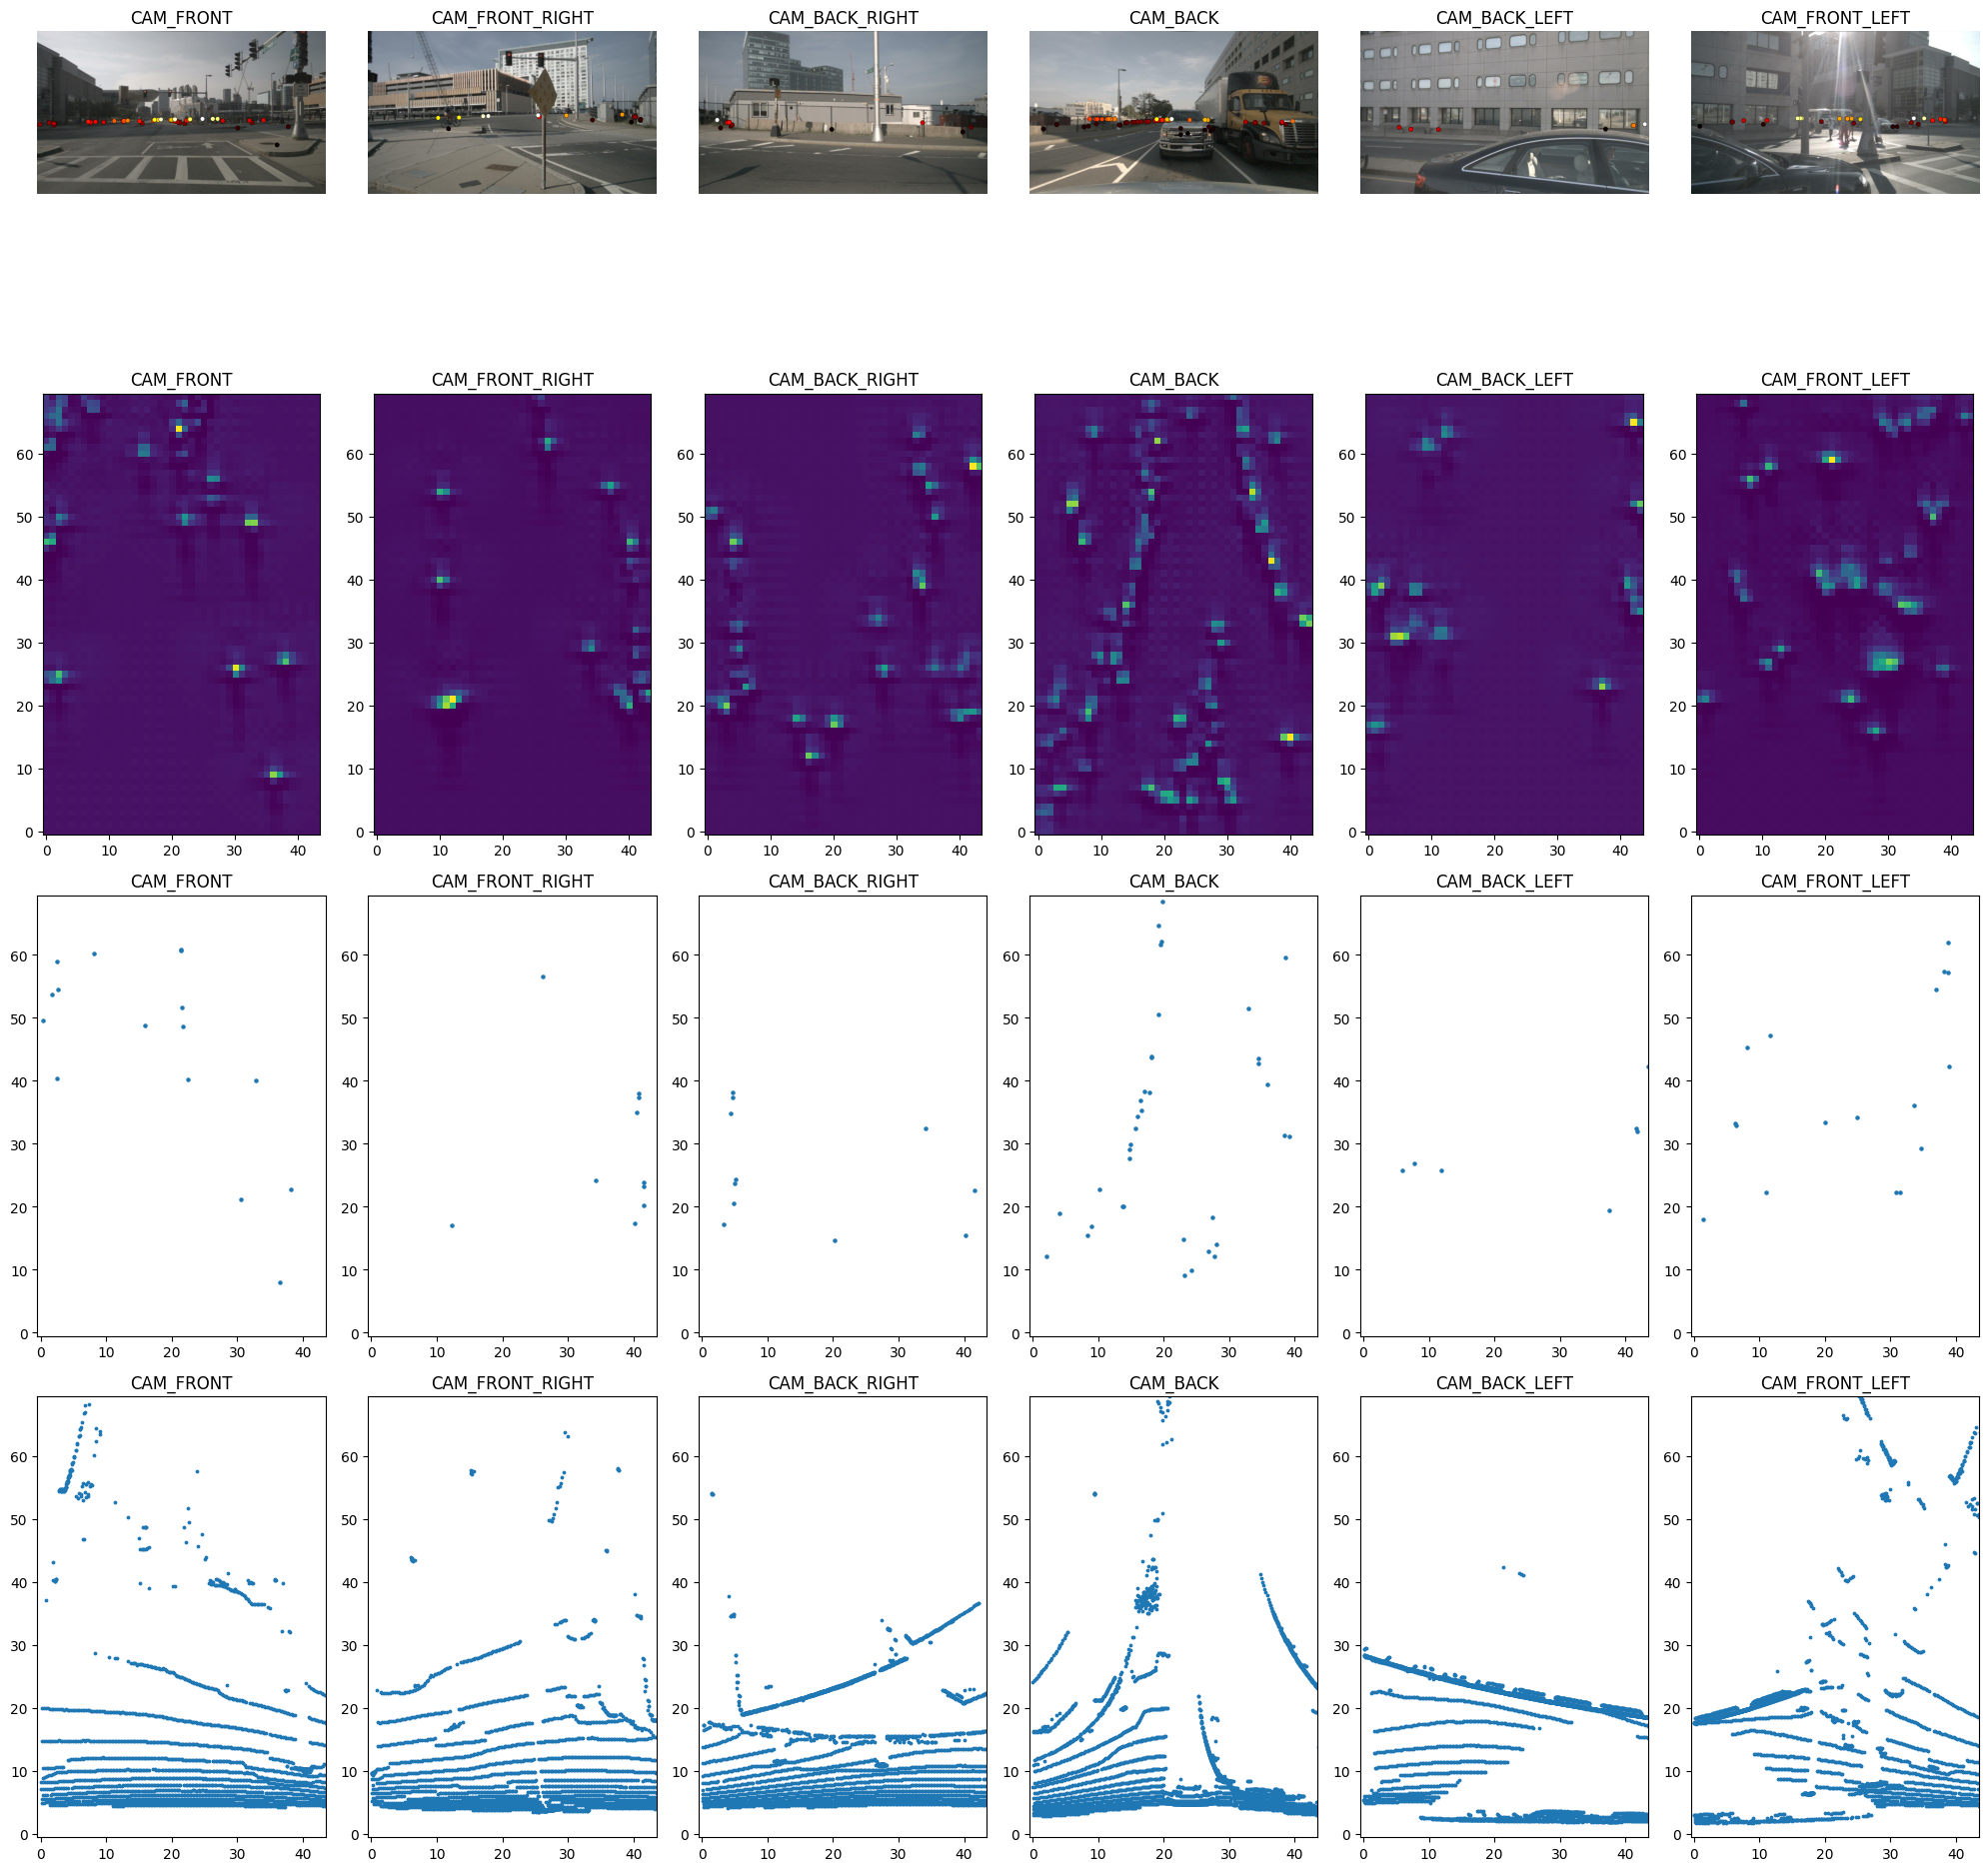

In [20]:
# axes_limit = (51.2-0.5, 44-0.5)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 20))
index_ax = [5,0,1,4,3,2]
for i in range(6):
    # image
    channel = camera_channel[i]
    im = im_result[channel]
    # point cloud
    x = points_result_origin[channel][0, :]
    y = points_result_origin[channel][1, :]
    c = depth_result_origin[channel]
    axes[0][i].scatter(x,y,c=c,cmap='hot', s=10, edgecolor='black', linewidth=0.2)
    axes[0][i].imshow(im)
    axes[0][i].set_title(channel)
    axes[0][i].axis('off')

    # resize_factor = 51.2 / occupancy.shape[3]
    # resized_image = zoom(occupancy[i][0][0].astype(np.float32), (resize_factor, 1), order=1)
    im = axes[1][index_ax[i]].imshow(occupancy[i][0][0], cmap='viridis')
    axes[1][i].set_title(camera[i])
    axes[1][index_ax[i]].set_xlim(-0.5, axes_limit[1])
    axes[1][index_ax[i]].set_ylim(-0.5, axes_limit[0])
    # axes[0][index_ax[i]].axis('off')
    # fig.colorbar(im, ax=axes[1][i], fraction=0.08, pad=0.04)
    
    im = axes[2][i].scatter(points_result_R[camera[i]][0],points_result_R[camera[i]][1], s=5)
    axes[2][i].set_title(camera[i])
    axes[2][i].set_xlim(-0.5, axes_limit[1])
    axes[2][i].set_ylim(-0.5, axes_limit[0])
    # axes[2][index_ax[i]].axis('off')
    
    im = axes[3][i].scatter(points_result_L[camera[i]][0],points_result_L[camera[i]][1], s=3)
    axes[3][i].set_title(camera[i])
    axes[3][i].set_xlim(-0.5, axes_limit[1])
    axes[3][i].set_ylim(-0.5, axes_limit[0])
    # axes[1][index_ax[i]].axis('off')

plt.tight_layout()
plt.savefig('/home/byounghun/workspace/CRN/occupancy/occupancy_of_sample_'+str(index)+'.png', bbox_inches='tight', pad_inches=0, dpi=200)

In [2]:
index = [0]

In [13]:
radar_pc_total = []
lidar_pc_total = []

for i in tqdm(range(len(index))):
    radar_pc = nusc.make_points_list('r', i, nsweeps=1).astype(np.float16)
    lidar_pc = nusc.make_points_list('l', i, nsweeps=1).astype(np.float16)

    radar_pc_total.extend(radar_pc)
    lidar_pc_total.extend(lidar_pc)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.73it/s]


In [14]:
radar_pc_total

[array([11.74  ,  5.332 ,  0.4963], dtype=float16),
 array([13.15  ,  4.336 ,  0.4956], dtype=float16),
 array([14.34 ,  4.54 ,  0.495], dtype=float16),
 array([13.586, -6.863,  0.495], dtype=float16),
 array([13.79  , -8.266 ,  0.4949], dtype=float16),
 array([16.75 ,  4.55 ,  0.494], dtype=float16),
 array([15.984, -6.855,  0.494], dtype=float16),
 array([17.55  ,  2.951 ,  0.4934], dtype=float16),
 array([17.55  ,  5.55  ,  0.4934], dtype=float16),
 array([17.39  , -7.25  ,  0.4932], dtype=float16),
 array([19.14  ,  4.758 ,  0.4927], dtype=float16),
 array([20.55  ,  4.363 ,  0.4922], dtype=float16),
 array([20.14  ,  6.562 ,  0.4924], dtype=float16),
 array([17.11 , 12.15 ,  0.494], dtype=float16),
 array([17.52  , 11.95  ,  0.4937], dtype=float16),
 array([22.73  ,  6.57  ,  0.4912], dtype=float16),
 array([24.34  ,  6.176 ,  0.4902], dtype=float16),
 array([21.11 , 13.164,  0.492], dtype=float16),
 array([21.9   , 12.766 ,  0.4917], dtype=float16),
 array([25.6   , -7.617 ,  0.4

In [18]:
def cartesian_to_polar(coordinates):
    """
    Convert a list of 3D Cartesian coordinates to 2D polar coordinates.
    The z coordinate is ignored.

    Parameters:
    coordinates (list of tuples): A list of tuples, each representing (x, y, z) coordinates.

    Returns:
    list of tuples: A list of tuples, each representing (r, theta) coordinates.
    """
    polar_coordinates = []
    for x, y, _ in coordinates:  # Z coordinate is ignored
        r = mt.sqrt(x**2 + y**2)
        theta = mt.atan2(y, x)  # atan2 handles the case when x is 0
        polar_coordinates.append((r, mt.degrees(theta)))  # Convert theta to degrees for readability
    
    return polar_coordinates

In [19]:
polar_coord = cartesian_to_polar(radar_pc_total)
polar_coord

[(12.89610501415574, 24.422410155007555),
 (13.844918298614568, 18.250915902762795),
 (15.044808155686342, 17.559912985945093),
 (15.22111452129928, -26.80178207632617),
 (16.07665392018909, -30.939881302389043),
 (17.357191880755124, 15.199703660112453),
 (17.392460893239104, -23.213797744870252),
 (17.793320030320817, 9.54710521787698),
 (18.40391248487605, 17.55425471298724),
 (18.841346498873826, -22.630829947813382),
 (19.723090659827665, 13.959181268916653),
 (21.00505404735314, 11.989082498613987),
 (21.182803913566897, 18.04736956894433),
 (20.983690013485027, 35.376491215758584),
 (21.205525610233057, 34.31065971078775),
 (23.66475888295254, 16.119475595067076),
 (25.114904700403535, 14.235088786584702),
 (24.87766577463672, 31.94816564495318),
 (25.3543876026049, 30.23102094751769),
 (26.703212999050436, -16.574007756908987),
 (28.233352752402638, -15.643773180281253),
 (29.305144666188735, 44.006281453001485),
 (31.17911711964198, -14.488903613622691),
 (30.606507490748598, 